## REDD - Washing Machine

### Data prepration
Loading Training and Test data


In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from keras.models import load_model
from glob import glob

from keras.layers import Input, Dense, Flatten, MaxPooling1D, AveragePooling1D, Convolution1D,LSTM,Reshape,Bidirectional
from keras.layers.merge import concatenate
from keras.models import Model,model_from_json
import keras.callbacks
from keras.callbacks import ModelCheckpoint
from keras.utils import plot_model
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

Using TensorFlow backend.


In [2]:
def load_data(appliance,house):
    X_train = np.load('pre_processed/x_train_{}_{}.npy'.format(appliance,house))
    Y_train = np.load('pre_processed/y_train_{}_{}.npy'.format(appliance,house))
    X_valid = np.load('pre_processed/x_valid_{}_{}.npy'.format(appliance,house))
    Y_valid = np.load('pre_processed/y_valid_{}_{}.npy'.format(appliance,house))
    X_test = np.load('pre_processed/x_test_{}_{}.npy'.format(appliance,house))
    Y_test = np.load('pre_processed/y_test_{}_{}.npy'.format(appliance,house))
    return X_train,Y_train,X_valid,Y_valid,X_test,Y_test


def scores(Y_pred, Y_test, activation_threshold = 0.1 ,plot_results= True,  print_results = False):

    """
    a function that computes the classification scores with various metrics
    return: dictionary with the various scores

    """

    # post process the data

    np.putmask(Y_pred[:,0], Y_pred[:,0] <=0, 0)
    np.putmask(Y_pred[:,1], Y_pred[:,1] >=1, 1)
    np.putmask(Y_pred[:,0],Y_pred[:,1] < Y_pred[:,0],0)
    np.putmask(Y_pred[:,1],Y_pred[:,1] < Y_pred[:,0],0)
    np.putmask(Y_pred[:,1],Y_pred[:,2] < activation_threshold,0)
    np.putmask(Y_pred[:,0],Y_pred[:,2] < activation_threshold,0)    

    # find negative in prediction
    pred_negatives = (Y_pred[:,0] ==0) &(Y_pred[:,1] ==0)
    pred_positives = ~pred_negatives
    obs_negatives = (Y_test[:,0] ==0) &(Y_test[:,1] ==0)
    obs_positives = ~obs_negatives
    TP = obs_positives[pred_positives].sum()
    FN = obs_positives[pred_negatives].sum()
    TN = obs_negatives[pred_negatives].sum()
    FP = obs_negatives[pred_positives].sum()

    recall = TP / float(TP + FN)
    precision = TP / float(TP+ FP)
    f1 = 2* precision*recall / (precision + recall)
    accuracy = (TP + TN)/ float(obs_negatives.sum() +obs_positives.sum() )
    if print_results:
        print('number of Predicted negatives:',pred_negatives.sum() )
        print('number of Predicted positives:',pred_positives.sum() )
        print('number of Observed negatives:', obs_negatives.sum() )
        print('number of Observed positives:', obs_positives.sum() )
        print('f1:',  f1)
        print('precision :' ,precision)
        print('recall : ', recall)
        print('accuracy:', accuracy)

    results = {
            'accuracy': accuracy,
            'f1_score': f1,
            'precision': precision,
            'recall_score': recall}
    if plot_results:
        pd_results = pd.DataFrame.from_dict(results, orient = 'index')
        pd_results = pd_results.transpose()    
        sns.barplot(data = pd_results)

    return results

def predict_and_evaluate(model,xtest,ytest):
    ypred = model.predict(xtest)
    return scores(ypred,ytest)

def scores(Y_pred, Y_test, activation_threshold = 0.1 ,plot_results= True,  print_results = False):

    """
    a function that computes the classification scores with various metrics
    return: dictionary with the various scores

    """

    # post process the data

    np.putmask(Y_pred[:,0], Y_pred[:,0] <=0, 0)
    np.putmask(Y_pred[:,1], Y_pred[:,1] >=1, 1)
    np.putmask(Y_pred[:,0],Y_pred[:,1] < Y_pred[:,0],0)
    np.putmask(Y_pred[:,1],Y_pred[:,1] < Y_pred[:,0],0)
    np.putmask(Y_pred[:,1],Y_pred[:,2] < activation_threshold,0)
    np.putmask(Y_pred[:,0],Y_pred[:,2] < activation_threshold,0)    

    # find negative in prediction
    pred_negatives = (Y_pred[:,0] ==0) &(Y_pred[:,1] ==0)
    pred_positives = ~pred_negatives
    obs_negatives = (Y_test[:,0] ==0) &(Y_test[:,1] ==0)
    obs_positives = ~obs_negatives
    TP = obs_positives[pred_positives].sum()
    FN = obs_positives[pred_negatives].sum()
    TN = obs_negatives[pred_negatives].sum()
    FP = obs_negatives[pred_positives].sum()

    recall = TP / float(TP + FN)
    precision = TP / float(TP+ FP)
    f1 = 2* precision*recall / (precision + recall)
    accuracy = (TP + TN)/ float(obs_negatives.sum() +obs_positives.sum() )
    if print_results:
        print('number of Predicted negatives:',pred_negatives.sum() )
        print('number of Predicted positives:',pred_positives.sum() )
        print('number of Observed negatives:', obs_negatives.sum() )
        print('number of Observed positives:', obs_positives.sum() )
        print('f1:',  f1)
        print('precision :' ,precision)
        print('recall : ', recall)
        print('accuracy:', accuracy)

    results = {
            'accuracy': accuracy,
            'f1_score': f1,
            'precision': precision,
            'recall_score': recall}
    if plot_results:
        pd_results = pd.DataFrame.from_dict(results, orient = 'index')
        pd_results = pd_results.transpose()    
        sns.barplot(data = pd_results)

    return results

def predict_and_evaluate(model,xtest,ytest):
    ypred = model.predict(xtest)
    return scores(ypred,ytest)

class LossHistory(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.train_losses = [] 
        self.valid_losses = []

    def on_epoch_end(self, epoch, logs = {}):
        self.train_losses.append(logs.get('loss'))
        self.valid_losses.append(logs.get('val_loss'))
  
    def plot_losses(history):
        losses_dict = {'loss': history.history['loss'], 'val_loss':history.history['val_loss']}
        plt.plot(history.history['loss'],label='Training Loss')
        plt.plot(history.history['val_loss'],label='Validation Loss')
        plt.title('Training vs Validation Loss')
        plt.legend()
        plt.show()

In [3]:
def create_fit_predict(model,filename,train_data,valid_data,test_data,**kwargs):
    model,history,checkpointer = model(filename)
    model_history = model.fit(train_data[0],train_data[1],validation_data=(valid_data[0],valid_data[1]),callbacks=[checkpointer],**kwargs)
    model.load_weights(filename)
    plot_losses(model_history)
    preds = model.predict(test_data[0])
    return scores(preds,test_data[1])

#### Loading the Data

In [4]:
appliance = 'washing machine'

In [5]:
xtrain,ytrain,xvalid,yvalid,xtest,ytest = load_data(appliance,3)

In [6]:
seq_length = xtrain.shape[1]
seq_length

512

## Start-Middle-End Power Models

### Model 1 - ConvNET 

In [7]:
def create_model_1(weights_path):
    input_seq = Input(shape = (seq_length, 1))
    # first convolutional layer
    conv1_layer =  Convolution1D(filters = 16, kernel_size = 3, padding='valid',
                          kernel_initializer = 'normal', activation =  'relu')
    conv1 = conv1_layer(input_seq)
    # flatten the weights
    flat = Flatten()(conv1)
    # first dense layer
    dense1 = Dense(1024, activation = 'relu')(flat)
    # second dense layer
    dense2 = Dense(512, activation = 'relu', kernel_initializer= 'normal')(dense1)
    # output layer
    predictions = Dense(3, activation = 'linear')(dense2)   
    # create the model
    model = Model(inputs=input_seq, outputs=predictions)
    # compile the model -- define the loss and the optimizer
    model.compile(loss='mean_squared_error', optimizer='Adam')
    # record the loss history
    history = LossHistory()
    # save the weigths when the vlaidation lost decreases only
    checkpointer = ModelCheckpoint(filepath=weights_path, save_best_only=True, verbose =1 )
    return model,history,checkpointer
    # fit the network using the generator of mini-batches.


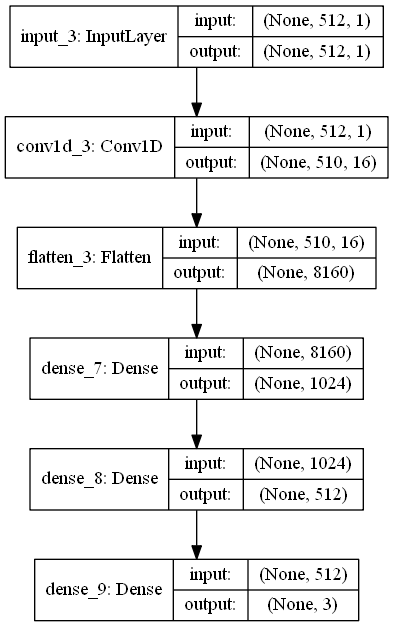

In [1]:
from IPython.display import Image
Image(filename='model1.png')

Train on 14992 samples, validate on 3200 samples
Epoch 1/40
14992/14992 [==============================] - 9s - loss: 0.1279 - val_loss: 0.1589
Epoch 2/40
14992/14992 [==============================] - 7s - loss: 0.0748 - val_loss: 0.1023
Epoch 3/40
14992/14992 [==============================] - 7s - loss: 0.0474 - val_loss: 0.0541
Epoch 4/40
14992/14992 [==============================] - 7s - loss: 0.0309 - val_loss: 0.0662
Epoch 5/40
14992/14992 [==============================] - 7s - loss: 0.0250 - val_loss: 0.0483
Epoch 6/40
14992/14992 [==============================] - 7s - loss: 0.0194 - val_loss: 0.0502
Epoch 7/40
14992/14992 [==============================] - 7s - loss: 0.0180 - val_loss: 0.0449
Epoch 8/40
14992/14992 [==============================] - 7s - loss: 0.0149 - val_loss: 0.0419
Epoch 9/40
14992/14992 [==============================] - 7s - loss: 0.0130 - val_loss: 0.0398
Epoch 10/40
14992/14992 [==============================] - 7s - loss: 0.0110 - val_loss: 0.0395


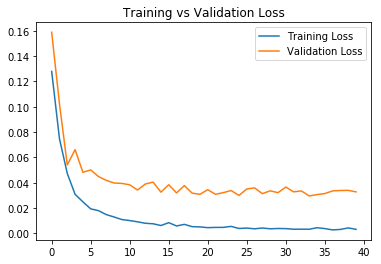

{'accuracy': 0.92312499999999997,
 'f1_score': 0.92730496453900713,
 'precision': 0.87182811631783663,
 'recall_score': 0.99032190195665892}

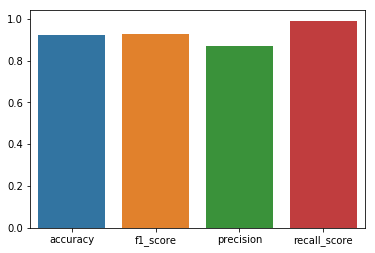

In [8]:
create_fit_predict(create_model_1,'model_1_{}.h5'.format(appliance),
                   [xtrain,ytrain],[xvalid,yvalid],[xtest,ytest],
                   epochs=40,batch_size=16)


### Model 2 - Deep CNN

In [9]:
def create_2_conv_model(path_to_weights):
    # input sequence
    input_seq = Input(shape = (seq_length, 1))
    # first convolutional layer
    conv1_layer =  Convolution1D(filters = 16, kernel_size = 3, padding='valid',
                          kernel_initializer = 'normal', activation =  'relu')
    conv1 = conv1_layer(input_seq)
    conv2 = Convolution1D(filters = 16, kernel_size = 3, padding='valid',
                          kernel_initializer = 'normal', activation =  'relu')(conv1)
    # flatten the weights
    flat = Flatten()(conv2)
    # first dense layer
    dense1 = Dense(1024, activation = 'relu')(flat)
    # second dense layer
    dense2 = Dense(512, activation = 'relu', kernel_initializer= 'normal')(dense1)
    # output layer
    predictions = Dense(3, activation = 'linear')(dense2)   
    # create the model
    model = Model(inputs=input_seq, outputs=predictions)
    # compile the model -- define the loss and the optimizer
    model.compile(loss='mean_squared_error', optimizer='Adam')
    # record the loss history
    history = LossHistory()
    # save the weigths when the vlaidation lost decreases only
    checkpointer = ModelCheckpoint(filepath=path_to_weights, save_best_only=True, verbose =1 )
    # fit the network using the generator of mini-batches.
    model.compile(loss='mean_squared_error', optimizer='sgd')
    model.summary()
 
    return model,history,checkpointer

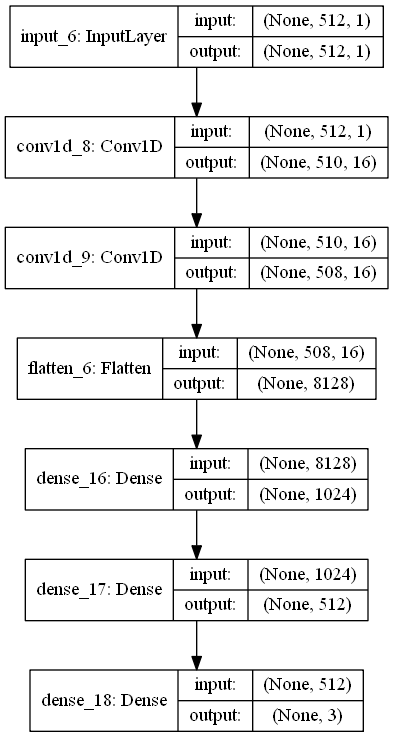

In [2]:
from IPython.display import Image
Image(filename='model2.png')

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 512, 1)            0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 510, 16)           64        
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 508, 16)           784       
_________________________________________________________________
flatten_2 (Flatten)          (None, 8128)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 1024)              8324096   
_________________________________________________________________
dense_5 (Dense)              (None, 512)               524800    
_________________________________________________________________
dense_6 (Dense)              (None, 3)                 1539      
Total para

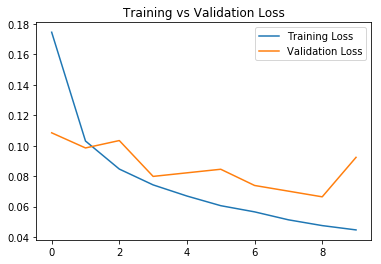

{'accuracy': 0.80822916666666667,
 'f1_score': 0.83534567569984786,
 'precision': 0.72650902302426879,
 'recall_score': 0.98253734483484112}

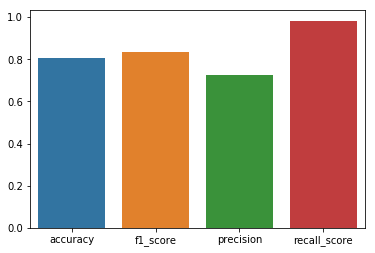

In [10]:
create_fit_predict(create_2_conv_model,'model_2_{}.h5'.format(appliance),
                   [xtrain,ytrain],[xvalid,yvalid],[xtest,ytest],
                   epochs=10,batch_size=16)

### Model 3 - Simple CNN + LSTM

In [11]:
def create_model_3(path_to_weights):
    input_seq = Input(shape = (seq_length, 1))
    # first convolutional layer
    conv1_layer =  Convolution1D(filters = 16, kernel_size = 3, padding='same',
                          kernel_initializer = 'normal', activation =  'relu')
    conv1 = conv1_layer(input_seq)
    # flatten the weights
    flat = Flatten()(conv1)
    reshaped = Reshape(target_shape=(seq_length,16))(flat)
    # first dense layer
    lstm = LSTM(128, activation = 'tanh')(reshaped)
    # second dense layer

    # output layer
    predictions = Dense(3, activation = 'linear')(lstm)   
    # create the model
    model = Model(inputs=input_seq, outputs=predictions)
    # compile the model -- define the loss and the optimizer
    model.compile(loss='mean_squared_error', optimizer='Adam')
    # record the loss history
    history = LossHistory()
    # save the weigths when the vlaidation lost decreases only
    checkpointer = ModelCheckpoint(filepath=path_to_weights, save_best_only=True, verbose =1 )
    model.summary()
    return model,history,checkpointer

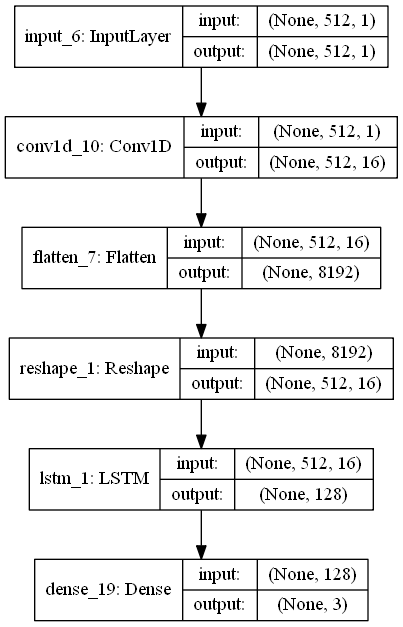

In [3]:
from IPython.display import Image
Image(filename='model3.png')

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 512, 1)            0         
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 512, 16)           64        
_________________________________________________________________
flatten_3 (Flatten)          (None, 8192)              0         
_________________________________________________________________
reshape_1 (Reshape)          (None, 512, 16)           0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 128)               74240     
_________________________________________________________________
dense_7 (Dense)              (None, 3)                 387       
Total params: 74,691
Trainable params: 74,691
Non-trainable params: 0
_________________________________________________________________
Train 

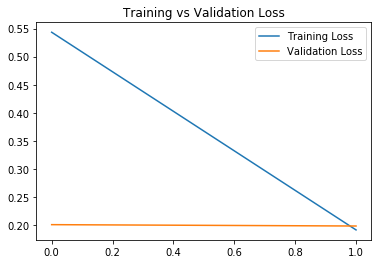

{'accuracy': 0.49510416666666668,
 'f1_score': 0.66230056434194939,
 'precision': 0.49510416666666668,
 'recall_score': 1.0}

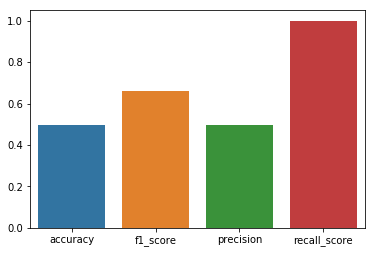

In [12]:
create_fit_predict(create_model_3,'model_3_{}.h5'.format(appliance),
                   [xtrain,ytrain],[xvalid,yvalid],[xtest,ytest],
                   epochs=2,batch_size=256)

### Model 4 - Parallel CNNs

In [13]:
def create_model_4(path_to_weights):
    input_seq = Input(shape = (seq_length, 1))
    # first convolutional layer
    conv1_layer =  Convolution1D(filters = 32, kernel_size = 3, padding='same',
                          kernel_initializer = 'normal', activation =  'relu')
    conv1_layer_2 =  Convolution1D(filters = 32, kernel_size = 5, padding='same',
                          kernel_initializer = 'normal', activation =  'relu')
    conv1_layer_3 =  Convolution1D(filters = 32, kernel_size = 7, padding='same',
                          kernel_initializer = 'normal', activation =  'relu')
    conv1 = conv1_layer(input_seq)
    conv2 = conv1_layer_2(input_seq)
    conv3 = conv1_layer_3(input_seq)
    merged = concatenate([conv1,conv2,conv3])
    
    # flatten the weights
    flat = Flatten()(merged)
    dense1 = Dense(128,activation='relu')(flat)
    dense2 = Dense(128,activation='relu')(dense1)
    # output layer
    predictions = Dense(3, activation = 'linear')(dense2)   
    # create the model
    model = Model(inputs=input_seq, outputs=predictions)
    # compile the model -- define the loss and the optimizer
    model.compile(loss='mean_squared_error', optimizer='Adam')
    # record the loss history
    history = LossHistory()
    # save the weigths when the vlaidation lost decreases only
    checkpointer = ModelCheckpoint(filepath=path_to_weights, save_best_only=True, verbose =1 )
    model.summary()
    return model,history,checkpointer

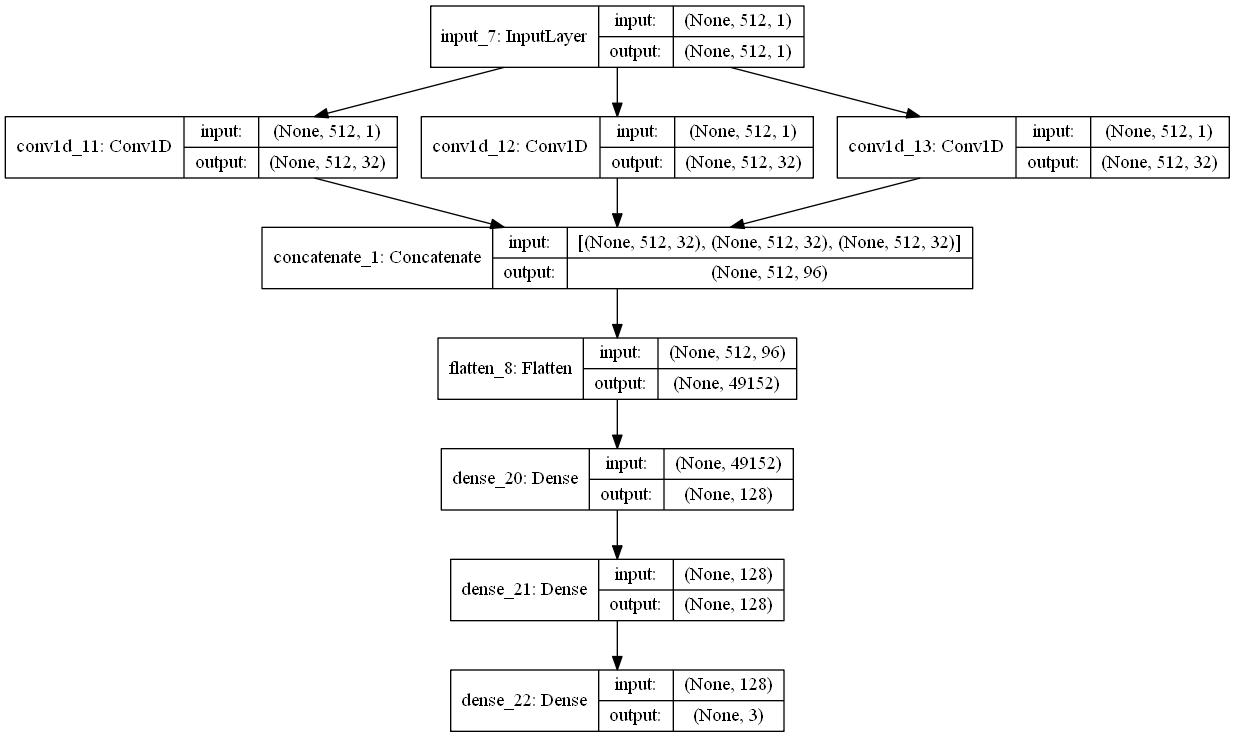

In [4]:
from IPython.display import Image
Image(filename='model4.png')

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_4 (InputLayer)             (None, 512, 1)        0                                            
____________________________________________________________________________________________________
conv1d_5 (Conv1D)                (None, 512, 32)       128         input_4[0][0]                    
____________________________________________________________________________________________________
conv1d_6 (Conv1D)                (None, 512, 32)       192         input_4[0][0]                    
____________________________________________________________________________________________________
conv1d_7 (Conv1D)                (None, 512, 32)       256         input_4[0][0]                    
___________________________________________________________________________________________

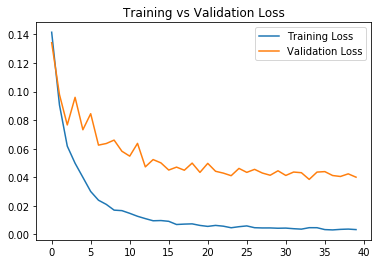

{'accuracy': 0.90249999999999997,
 'f1_score': 0.91000000000000003,
 'precision': 0.83796706215689742,
 'recall_score': 0.9955817378497791}

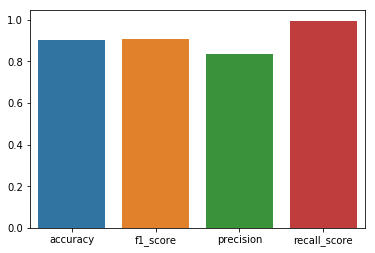

In [14]:
create_fit_predict(create_model_4,'model_4_{}.h5'.format(appliance),
                   [xtrain,ytrain],[xvalid,yvalid],[xtest,ytest],
                   epochs=40,batch_size=16)

### Model 5 - Parallel CNNs with Bidirectional LSTM

In [15]:
def create_model_5(path_to_weights):
    input_seq = Input(shape = (seq_length, 1))
    # first convolutional layer
    conv1_layer =  Convolution1D(filters = 32, kernel_size = 3, padding='same',
                          kernel_initializer = 'normal', activation =  'relu')
    conv1_layer_2 =  Convolution1D(filters = 32, kernel_size = 5, padding='same',
                          kernel_initializer = 'normal', activation =  'relu')
    conv1_layer_3 =  Convolution1D(filters = 32, kernel_size = 7, padding='same',
                          kernel_initializer = 'normal', activation =  'relu')
    conv1 = conv1_layer(input_seq)
    conv2 = conv1_layer_2(input_seq)
    conv3 = conv1_layer_3(input_seq)
    merged = concatenate([conv1,conv2,conv3])
    bidirectional_lstm1 = Bidirectional(LSTM(128,activation='tanh',return_sequences=True))(merged)
    bidirectional_lstm2 = Bidirectional(LSTM(128,activation='tanh'))(bidirectional_lstm1)
    # flatten the weights
    dense1 = Dense(128,activation='relu')(bidirectional_lstm2)
    # output layer
    predictions = Dense(3, activation = 'linear')(dense1)   
    # create the model
    model = Model(inputs=input_seq, outputs=predictions)
    # compile the model -- define the loss and the optimizer
    model.compile(loss='mean_squared_error', optimizer='Adam')
    # record the loss history
    history = LossHistory()
    # save the weigths when the vlaidation lost decreases only
    checkpointer = ModelCheckpoint(filepath=path_to_weights, save_best_only=True, verbose =1 )
    model.summary()
    return model,history,checkpointer

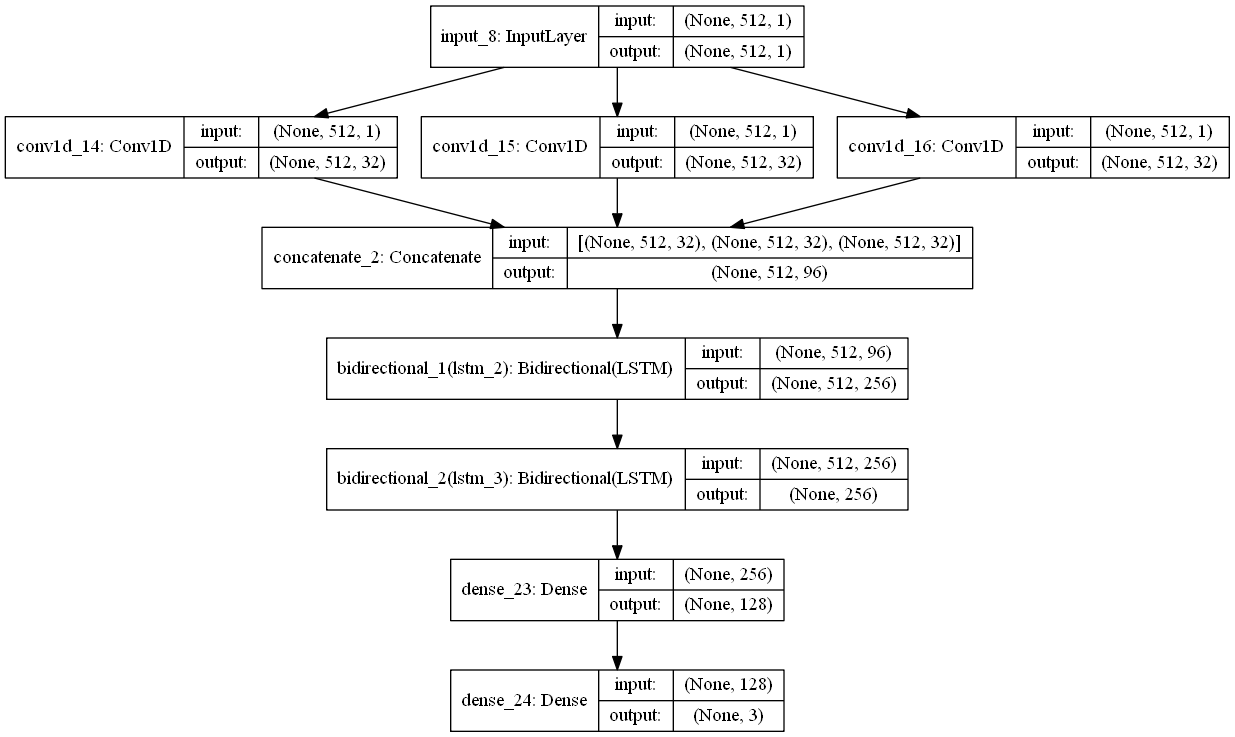

In [5]:
from IPython.display import Image
Image(filename='model5.png')

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_5 (InputLayer)             (None, 512, 1)        0                                            
____________________________________________________________________________________________________
conv1d_8 (Conv1D)                (None, 512, 32)       128         input_5[0][0]                    
____________________________________________________________________________________________________
conv1d_9 (Conv1D)                (None, 512, 32)       192         input_5[0][0]                    
____________________________________________________________________________________________________
conv1d_10 (Conv1D)               (None, 512, 32)       256         input_5[0][0]                    
___________________________________________________________________________________________

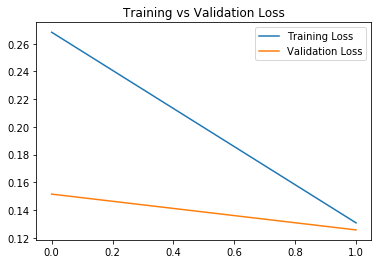

{'accuracy': 0.81489583333333337,
 'f1_score': 0.84225477141588978,
 'precision': 0.72850122850122845,
 'recall_score': 0.99810645907847673}

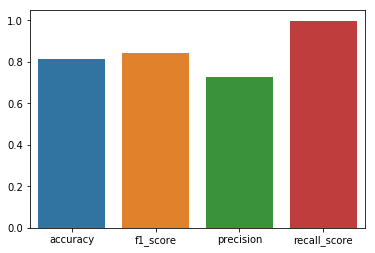

In [16]:
create_fit_predict(create_model_5,'model_5_{}.h5'.format(appliance),
                   [xtrain,ytrain],[xvalid,yvalid],[xtest,ytest],
                   epochs=2,batch_size=256)

# Sequence to Sequence Models

In [17]:
# Helper Functions
def load_data_sequence(appliance,house):
    X_train = np.load('pre_processed/x_train_{}_{}_seq.npy'.format(appliance,house))
    Y_train = np.load('pre_processed/y_train_{}_{}_seq.npy'.format(appliance,house))
    X_valid = np.load('pre_processed/x_valid_{}_{}_seq.npy'.format(appliance,house))
    Y_valid = np.load('pre_processed/y_valid_{}_{}_seq.npy'.format(appliance,house))
    X_test = np.load('pre_processed/x_test_{}_{}_seq.npy'.format(appliance,house))
    Y_test = np.load('pre_processed/y_test_{}_{}_seq.npy'.format(appliance,house))
    return X_train,Y_train,X_valid,Y_valid,X_test,Y_test

def scores_sequence(Y_pred, Y_test, activation_threshold = 0.1 ,plot_results= True,  print_results = False):

    """
    a function that computes the classification scores with various metrics
    return: dictionary with the various scores

    """

    # post process the data

    np.putmask(Y_pred[:,0], Y_pred[:,0] <=0, 0)
    np.putmask(Y_pred[:,1], Y_pred[:,1] >=1, 1)
    np.putmask(Y_pred[:,0],Y_pred[:,1] < Y_pred[:,0],0)
    np.putmask(Y_pred[:,1],Y_pred[:,1] < Y_pred[:,0],0)
    np.putmask(Y_pred[:,1],Y_pred[:,2] < activation_threshold,0)
    np.putmask(Y_pred[:,0],Y_pred[:,2] < activation_threshold,0)    

    # find negative in prediction
    pred_negatives = (Y_pred[:,0] ==0) &(Y_pred[:,1] ==0)
    pred_positives = ~pred_negatives
    obs_negatives = (Y_test[:,0] ==0) &(Y_test[:,1] ==0)
    obs_positives = ~obs_negatives
    TP = obs_positives[pred_positives].sum()
    FN = obs_positives[pred_negatives].sum()
    TN = obs_negatives[pred_negatives].sum()
    FP = obs_negatives[pred_positives].sum()

    recall = TP / float(TP + FN)
    precision = TP / float(TP+ FP)
    f1 = 2* precision*recall / (precision + recall)
    accuracy = (TP + TN)/ float(obs_negatives.sum() +obs_positives.sum() )
    if print_results:
        print('number of Predicted negatives:',pred_negatives.sum() )
        print('number of Predicted positives:',pred_positives.sum() )
        print('number of Observed negatives:', obs_negatives.sum() )
        print('number of Observed positives:', obs_positives.sum() )
        print('f1:',  f1)
        print('precision :' ,precision)
        print('recall : ', recall)
        print('accuracy:', accuracy)

    results = {
            'accuracy': accuracy,
            'f1_score': f1,
            'precision': precision,
            'recall_score': recall}
    if plot_results:
        pd_results = pd.DataFrame.from_dict(results, orient = 'index')
        pd_results = pd_results.transpose()    
        sns.barplot(data = pd_results)

    return results


def plot_seq(Y_pred,Y_valid_sequences):
    plt.figure(figsize=(12,4))
    sns.tsplot(Y_pred)
    sns.tsplot(Y_valid_sequences,color='red')
    plt.legend()
    plt.show()
    
def score_sequence_other(y_true,y_pred,plot_results=True):
    Y_pred_bin = y_pred.copy()
    Y_valid_bin = y_true.copy()
    np.putmask(Y_pred_bin,Y_pred_bin >= 0.1,1)
    np.putmask(Y_valid_bin,Y_valid_bin >= 0.1,1)
    np.putmask(Y_pred_bin,Y_pred_bin < 0.1,0)
    np.putmask(Y_valid_bin,Y_valid_bin < 0.1,0)
    results_arr = []
    for i,sequence in enumerate(Y_pred_bin):
        seq_accuracy = accuracy_score(Y_valid_bin[i],Y_pred_bin[i])
        s_precision,s_recall,s_f1,s_sup = precision_recall_fscore_support(Y_valid_bin[i],Y_pred_bin[i])
        results_arr.append((seq_accuracy,s_precision[0],s_recall[0],s_f1[0]))
    summarized = np.mean(results_arr,axis=0)
    results = {
            'accuracy': summarized[0],
            'f1_score': summarized[3],
            'precision': summarized[1],
            'recall_score': summarized[2]}
    if plot_results:
        print(results)
        pd_results = pd.DataFrame.from_dict(results, orient = 'index')
        pd_results = pd_results.transpose()    
        sns.barplot(data = pd_results)
    return summarized,results

def predict_and_evaluate_sequences(model,xtest,ytest):
    ypred = model.predict(xtest)
    print(ypred.shape)
    return score_sequence_other(ytest,ypred)

def create_fit_predict_seq(model,filename,train_data,valid_data,test_data,**kwargs):
    model,history,checkpointer = model(filename)
    model_history = model.fit(train_data[0],train_data[1],validation_data=(valid_data[0],valid_data[1]),callbacks=[checkpointer],**kwargs)
    model.load_weights(filename)
    preds = model.predict(test_data[0])
    plot_losses(model_history)
    return score_sequence_other(preds,test_data[1])

def reshape_y(y):
    y = y.reshape(y.shape[0],y.shape[1])
    return y

In [18]:

xtrain_seq,ytrain_seq,xvalid_seq,yvalid_seq,xtest_seq,ytest_seq = load_data_sequence(appliance,3)

ytrain_seq = reshape_y(ytrain_seq)
yvalid_seq = reshape_y(yvalid_seq)
ytest_seq = reshape_y(ytest_seq)


print(xtrain_seq.shape,yvalid_seq.shape,ytrain_seq.shape,ytest_seq.shape)

(14992, 512, 1) (3200, 512) (14992, 512) (9600, 512)


## SEQ MODEL 1 -Simple CNN

In [19]:
def create_conv_model_seq(best_weights_file):
    # input sequence
    input_seq = Input(shape = (seq_length, 1))
    # first convolutional layer
    conv1_layer =  Convolution1D(filters = 16, kernel_size = 3, padding='valid',
                          kernel_initializer = 'normal', activation =  'relu')
    conv1 = conv1_layer(input_seq)
    conv2 = Convolution1D(filters = 16, kernel_size = 3, padding='valid',
                          kernel_initializer = 'normal', activation =  'relu')(conv1)
    # flatten the weights
    flat = Flatten()(conv2)
    # first dense layer
    dense1 = Dense(1024, activation = 'relu')(flat)
    # second dense layer
    dense2 = Dense(512, activation = 'relu', kernel_initializer= 'normal')(dense1)
    # output layer
    predictions = Dense(seq_length, activation = 'linear')(dense2)   
    # create the model
    model = Model(inputs=input_seq, outputs=predictions)
    # compile the model -- define the loss and the optimizer
    model.compile(loss='mean_squared_error', optimizer='Adam')
    # record the loss history
    history = LossHistory()
    # save the weigths when the vlaidation lost decreases only
    checkpointer = ModelCheckpoint(filepath=best_weights_file, save_best_only=True, verbose =1 )
    # fit the network using the generator of mini-batches.
    model.compile(loss='mean_squared_error', optimizer='sgd') 
    return model,history,checkpointer


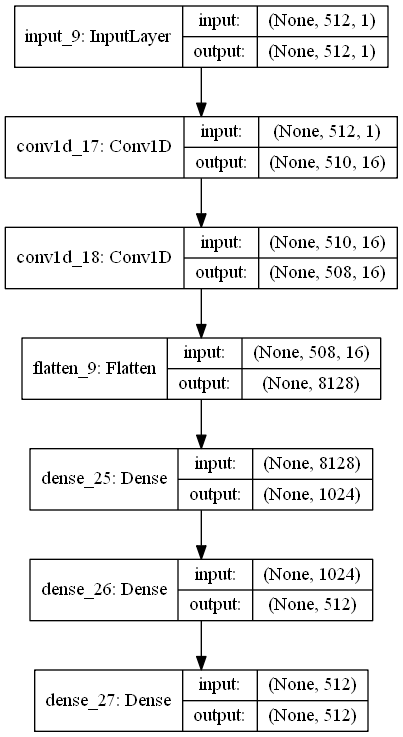

In [6]:
from IPython.display import Image
Image(filename='model6.png')

Train on 14992 samples, validate on 3200 samples
Epoch 1/60
14992/14992 [==============================] - 2s - loss: 2.8621 - val_loss: 4.5611
Epoch 2/60
14992/14992 [==============================] - 1s - loss: 2.7892 - val_loss: 4.2316
Epoch 3/60
14992/14992 [==============================] - 1s - loss: 2.1366 - val_loss: 2.8985
Epoch 4/60
14992/14992 [==============================] - 1s - loss: 1.7483 - val_loss: 2.7744
Epoch 5/60
14992/14992 [==============================] - 1s - loss: 1.6451 - val_loss: 2.5719
Epoch 6/60
14992/14992 [==============================] - 1s - loss: 1.4915 - val_loss: 2.3466
Epoch 7/60
14992/14992 [==============================] - 1s - loss: 1.3552 - val_loss: 2.1472
Epoch 8/60
14992/14992 [==============================] - 1s - loss: 1.2434 - val_loss: 1.9803
Epoch 9/60
14992/14992 [==============================] - 1s - loss: 1.1404 - val_loss: 1.8173
Epoch 10/60
14992/14992 [==============================] - 1s - loss: 1.0449 - val_loss: 1.6829


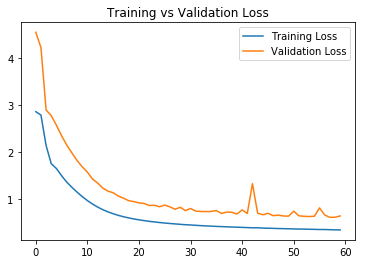

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


{'accuracy': 0.76765157063802081, 'f1_score': 0.6957148671225758, 'precision': 0.64582068864854769, 'recall_score': 0.79873141436882078}


(array([ 0.76765157,  0.64582069,  0.79873141,  0.69571487]),
 {'accuracy': 0.76765157063802081,
  'f1_score': 0.6957148671225758,
  'precision': 0.64582068864854769,
  'recall_score': 0.79873141436882078})

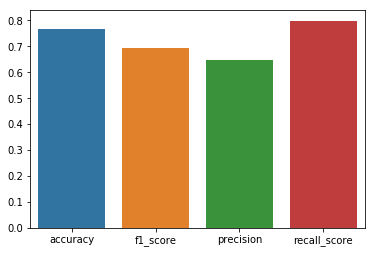

In [20]:
create_fit_predict_seq(create_conv_model_seq,'model_1_seq{}'.format(appliance),
                   [xtrain_seq,ytrain_seq],[xvalid_seq,yvalid_seq],[xtest_seq,ytest_seq],
                   epochs=60,batch_size=64)

## SEQ MODEL 2 - Parallel CNNs

In [21]:
def create_model_seq_2(path_to_weights):
    input_seq = Input(shape = (seq_length, 1))
    # first convolutional layer
    conv1_layer =  Convolution1D(filters = 32, kernel_size = 3, padding='same',
                          kernel_initializer = 'normal', activation =  'relu')
    conv1_layer_2 =  Convolution1D(filters = 32, kernel_size = 5, padding='same',
                          kernel_initializer = 'normal', activation =  'relu')
    conv1_layer_3 =  Convolution1D(filters = 32, kernel_size = 7, padding='same',
                          kernel_initializer = 'normal', activation =  'relu')
    conv1 = conv1_layer(input_seq)
    conv2 = conv1_layer_2(input_seq)
    conv3 = conv1_layer_3(input_seq)
    merged = concatenate([conv1,conv2,conv3])
    flat = Flatten()(merged)

    # flatten the weights
    dense1 = Dense(128,activation='relu')(flat)
    dense2 = Dense(128,activation='relu')(dense1)
    # output layer
    predictions = Dense(seq_length, activation = 'linear')(dense2)   
    # create the model
    model = Model(inputs=input_seq, outputs=predictions)
    # compile the model -- define the loss and the optimizer
    model.compile(loss='mean_squared_error', optimizer='Adam')
    # record the loss history
    history = LossHistory()
    # save the weigths when the vlaidation lost decreases only
    checkpointer = ModelCheckpoint(filepath=path_to_weights, save_best_only=True, verbose =1 )
    model.summary()
    return model,history,checkpointer

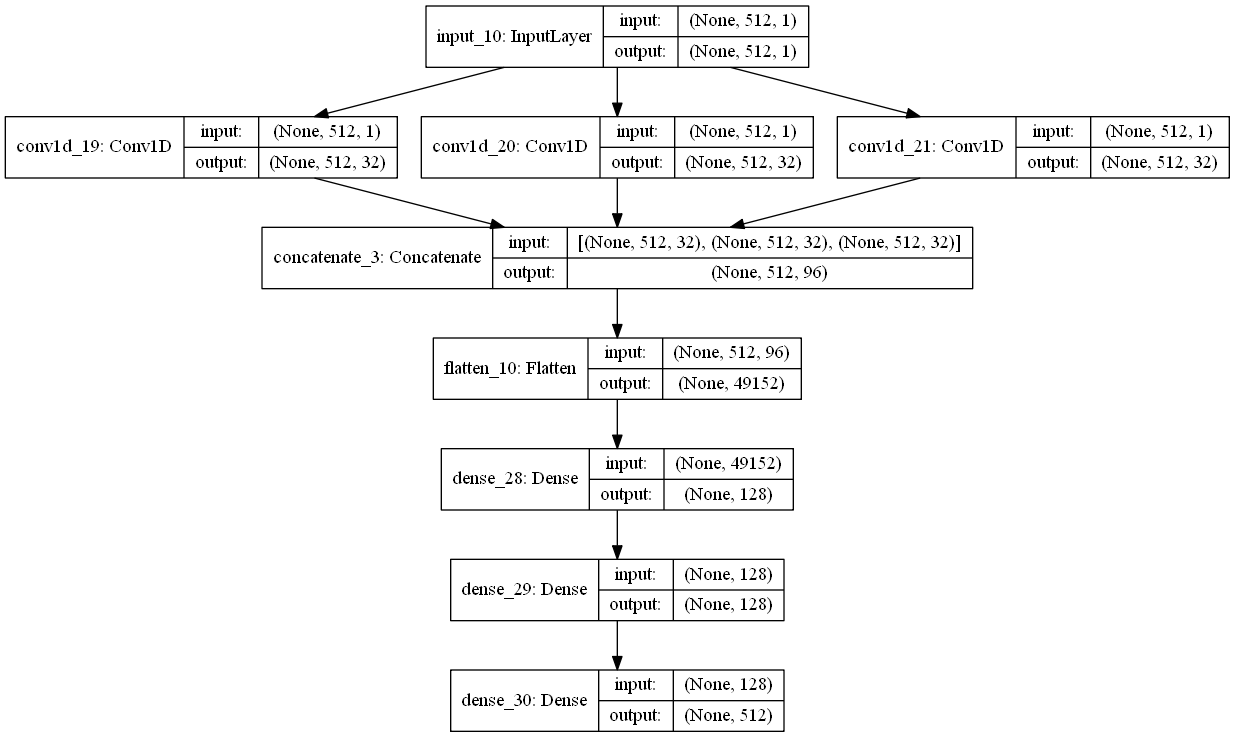

In [7]:
from IPython.display import Image
Image(filename='model7.png')

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_7 (InputLayer)             (None, 512, 1)        0                                            
____________________________________________________________________________________________________
conv1d_13 (Conv1D)               (None, 512, 32)       128         input_7[0][0]                    
____________________________________________________________________________________________________
conv1d_14 (Conv1D)               (None, 512, 32)       192         input_7[0][0]                    
____________________________________________________________________________________________________
conv1d_15 (Conv1D)               (None, 512, 32)       256         input_7[0][0]                    
___________________________________________________________________________________________

14992/14992 [==============================] - 1s - loss: 0.2321 - val_loss: 0.5807


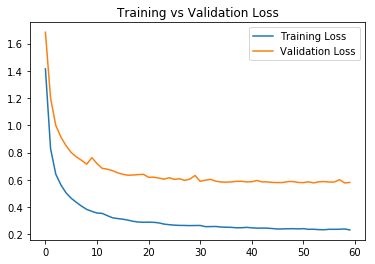

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


{'accuracy': 0.83514465332031251, 'f1_score': 0.73582233508484107, 'precision': 0.71680401355067214, 'recall_score': 0.79949228497504421}


(array([ 0.83514465,  0.71680401,  0.79949228,  0.73582234]),
 {'accuracy': 0.83514465332031251,
  'f1_score': 0.73582233508484107,
  'precision': 0.71680401355067214,
  'recall_score': 0.79949228497504421})

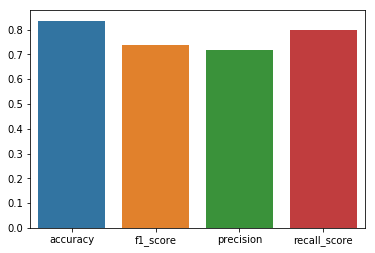

In [22]:
create_fit_predict_seq(create_model_seq_2,'model_2_seq{}'.format(appliance),
                   [xtrain_seq,ytrain_seq],[xvalid_seq,yvalid_seq],[xtest_seq,ytest_seq],
                   epochs=60,batch_size=128)

## SEQ MODEL 3 - Parallel CNNs + Bidirectional LSTM

In [23]:
def create_model_seq_3(path_to_weights):
    input_seq = Input(shape = (seq_length, 1))
    # first convolutional layer
    conv1_layer =  Convolution1D(filters = 32, kernel_size = 3, padding='same',
                          kernel_initializer = 'normal', activation =  'relu')
    conv1_layer_2 =  Convolution1D(filters = 32, kernel_size = 5, padding='same',
                          kernel_initializer = 'normal', activation =  'relu')
    conv1_layer_3 =  Convolution1D(filters = 32, kernel_size = 7, padding='same',
                          kernel_initializer = 'normal', activation =  'relu')
    conv1 = conv1_layer(input_seq)
    conv2 = conv1_layer_2(input_seq)
    conv3 = conv1_layer_3(input_seq)
    merged = concatenate([conv1,conv2,conv3])
    bidirectional_lstm1 = Bidirectional(LSTM(128,activation='tanh',return_sequences=True))(merged)
    bidirectional_lstm2 = Bidirectional(LSTM(128,activation='tanh'))(bidirectional_lstm1)
    # flatten the weights
    flat = Flatten()(merged)
    dense1 = Dense(128,activation='relu')(bidirectional_lstm2)
    # output layer
    predictions = Dense(seq_length, activation = 'linear')(dense1)   
    # create the model
    model = Model(inputs=input_seq, outputs=predictions)
    # compile the model -- define the loss and the optimizer
    model.compile(loss='mean_squared_error', optimizer='Adam')
    # record the loss history
    history = LossHistory()
    # save the weigths when the vlaidation lost decreases only
    checkpointer = ModelCheckpoint(filepath=path_to_weights, save_best_only=True, verbose =1 )
    model.summary()
    return model,history,checkpointer

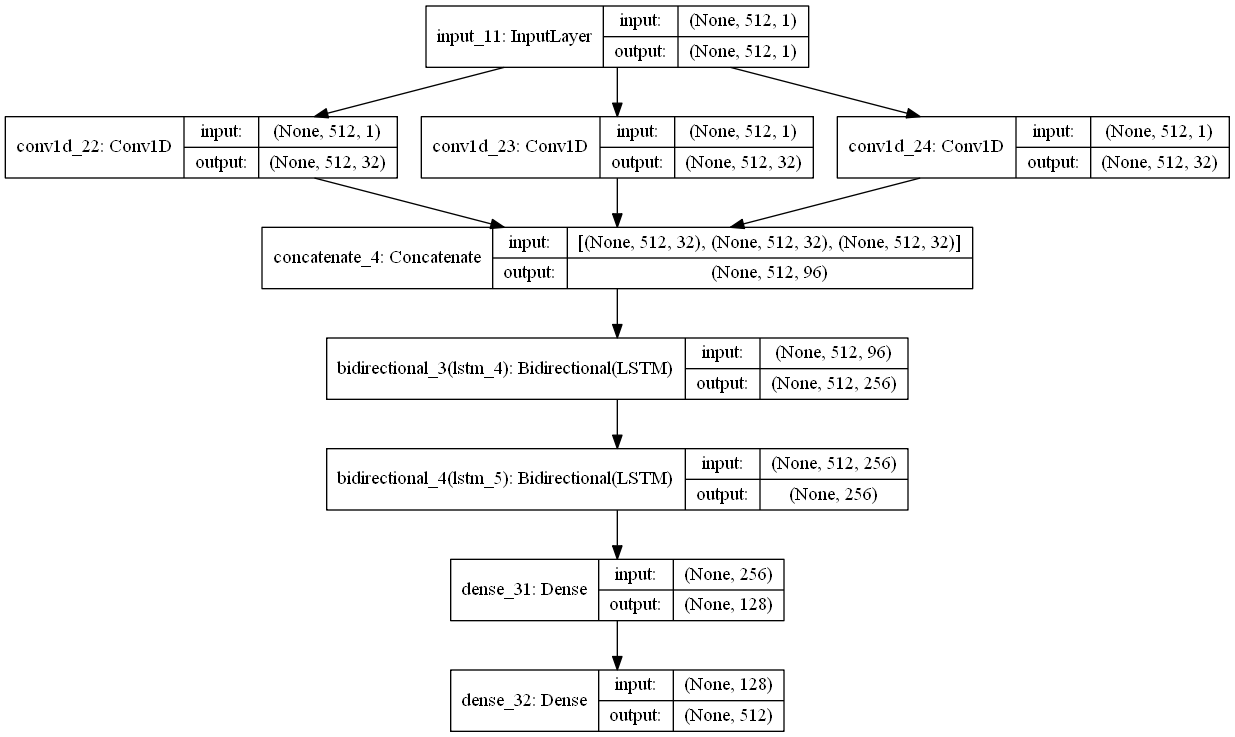

In [8]:
from IPython.display import Image
Image(filename='model8.png')

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_8 (InputLayer)             (None, 512, 1)        0                                            
____________________________________________________________________________________________________
conv1d_16 (Conv1D)               (None, 512, 32)       128         input_8[0][0]                    
____________________________________________________________________________________________________
conv1d_17 (Conv1D)               (None, 512, 32)       192         input_8[0][0]                    
____________________________________________________________________________________________________
conv1d_18 (Conv1D)               (None, 512, 32)       256         input_8[0][0]                    
___________________________________________________________________________________________

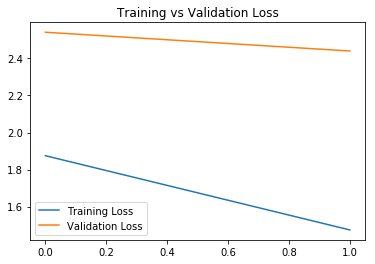

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


{'accuracy': 0.80718892415364585, 'f1_score': 0.72076811540560848, 'precision': 0.66131144115621998, 'recall_score': 0.92109346863892538}


(array([ 0.80718892,  0.66131144,  0.92109347,  0.72076812]),
 {'accuracy': 0.80718892415364585,
  'f1_score': 0.72076811540560848,
  'precision': 0.66131144115621998,
  'recall_score': 0.92109346863892538})

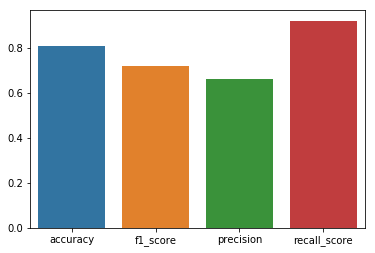

In [24]:
create_fit_predict_seq(create_model_seq_3,'model_3_seq{}'.format(appliance),
                   [xtrain_seq,ytrain_seq],[xvalid_seq,yvalid_seq],[xtest_seq,ytest_seq],
                   epochs=2,batch_size=256)

## SEQ MODEL 4 - Denoising AutoEncoder

In [25]:
def create_model_seq_4(path_to_weights):
    input_seq = Input(shape = (seq_length, 1))
    conv1 = Convolution1D(filters = 8, kernel_size = 4, padding='same',
                          kernel_initializer = 'normal', activation =  'linear')(input_seq)
    flat1 = Flatten()(conv1)
    dense1 = Dense(seq_length * 8,activation='relu')(flat1)
    dense2 = Dense(128,activation='relu')(dense1)
    
    dense3 = Dense(seq_length * 8,activation='relu')(dense2)
    reshaped_layer = Reshape((seq_length,-1))(dense3)
    
    conv2 = Convolution1D(filters = 1, kernel_size = 4, padding='same',
                          kernel_initializer = 'normal', activation =  'linear')(reshaped_layer)
    flat = Flatten()(conv2)
    
    # output layer
    predictions = Dense(seq_length, activation = 'linear')(flat)   
    # create the model
    model = Model(inputs=input_seq, outputs=predictions)
    # compile the model -- define the loss and the optimizer
    model.compile(loss='mean_squared_error', optimizer='Adam')
    # record the loss history
    history = LossHistory()
    # save the weigths when the vlaidation lost decreases only
    checkpointer = ModelCheckpoint(filepath=path_to_weights, save_best_only=True, verbose =1 )
    model.summary()
    return model,history,checkpointer

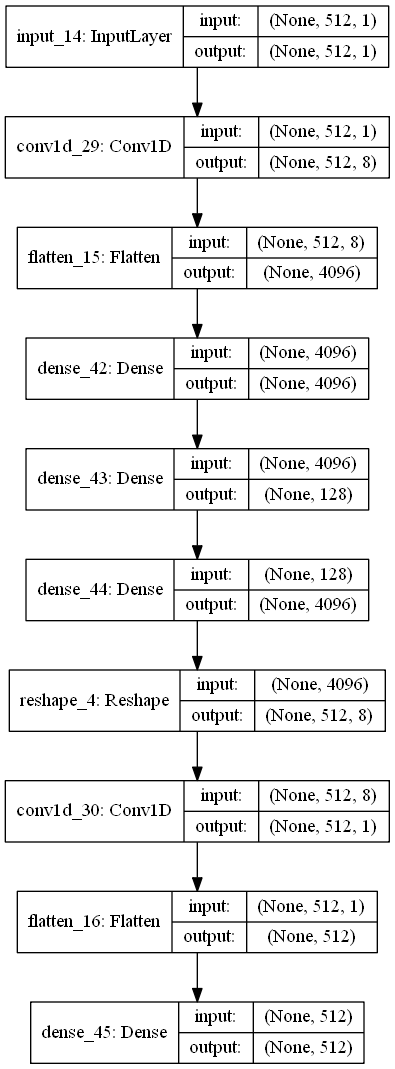

In [9]:
from IPython.display import Image
Image(filename='model9.png')

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_9 (InputLayer)         (None, 512, 1)            0         
_________________________________________________________________
conv1d_19 (Conv1D)           (None, 512, 8)            40        
_________________________________________________________________
flatten_8 (Flatten)          (None, 4096)              0         
_________________________________________________________________
dense_21 (Dense)             (None, 4096)              16781312  
_________________________________________________________________
dense_22 (Dense)             (None, 128)               524416    
_________________________________________________________________
dense_23 (Dense)             (None, 4096)              528384    
_________________________________________________________________
reshape_2 (Reshape)          (None, 512, 8)            0         
__________

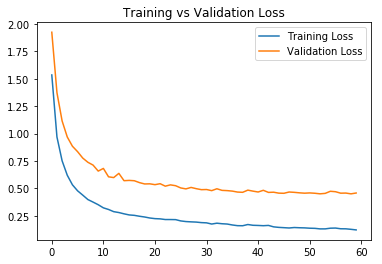

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


{'accuracy': 0.83636393229166661, 'f1_score': 0.74720464304324363, 'precision': 0.72264118020064105, 'recall_score': 0.81438350757798661}


(array([ 0.83636393,  0.72264118,  0.81438351,  0.74720464]),
 {'accuracy': 0.83636393229166661,
  'f1_score': 0.74720464304324363,
  'precision': 0.72264118020064105,
  'recall_score': 0.81438350757798661})

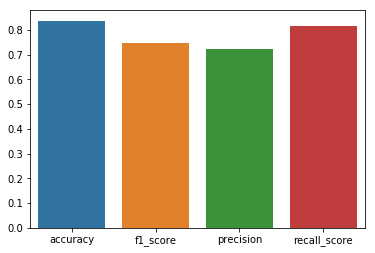

In [26]:
create_fit_predict_seq(create_model_seq_4,'model_4_seq{}'.format(appliance),
                   [xtrain_seq,ytrain_seq],[xvalid_seq,yvalid_seq],[xtest_seq,ytest_seq],
                   epochs=60,batch_size=128)

## SEQ MODEL 5 -Denoising Autoencoder + LSTM

In [27]:
def create_model_seq_5(path_to_weights):
    input_seq = Input(shape = (seq_length, 1))
    conv1 = Convolution1D(filters = 8, kernel_size = 4, padding='same',
                          kernel_initializer = 'normal', activation =  'linear')(input_seq)
    flat1 = Flatten()(conv1)
    dense1 = Dense(seq_length * 8,activation='relu')(flat1)
    dense2 = Dense(128,activation='relu')(dense1)
    
    dense3 = Dense(seq_length * 8,activation='relu')(dense2)
    reshaped_layer = Reshape((seq_length,-1))(dense3)
    
    conv2 = Convolution1D(filters = 1, kernel_size = 4, padding='same',
                          kernel_initializer = 'normal', activation =  'linear')(reshaped_layer)
    
    
    bidirectional_lstm1 = Bidirectional(LSTM(128,activation='tanh',return_sequences=True))(conv2)
    bidirectional_lstm2 = Bidirectional(LSTM(128,activation='tanh'))(bidirectional_lstm1)
    
    dense4 = Dense(1024,activation='relu')(bidirectional_lstm2)
    
    # output layer
    predictions = Dense(seq_length, activation = 'linear')(dense4)   
    # create the model
    model = Model(inputs=input_seq, outputs=predictions)
    # compile the model -- define the loss and the optimizer
    model.compile(loss='mean_squared_error', optimizer='Adam')
    # record the loss history
    history = LossHistory()
    # save the weigths when the vlaidation lost decreases only
    checkpointer = ModelCheckpoint(filepath=path_to_weights, save_best_only=True, verbose =1 )
    model.summary()
    return model,history,checkpointer

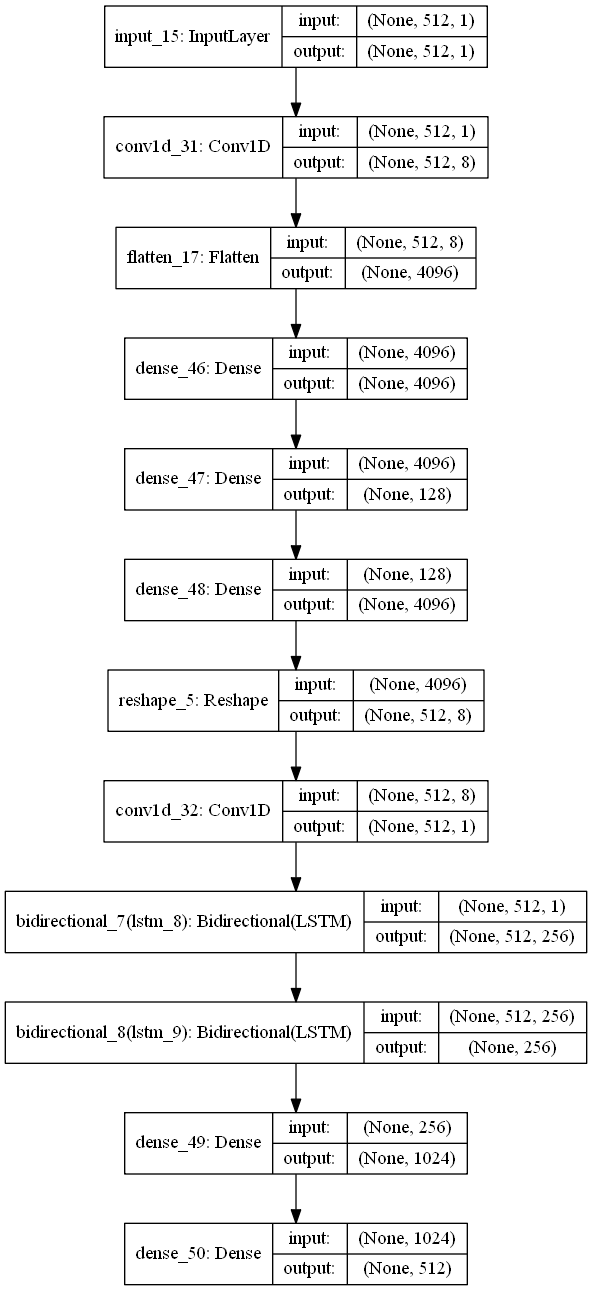

In [10]:
from IPython.display import Image
Image(filename='model10.png')

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_10 (InputLayer)        (None, 512, 1)            0         
_________________________________________________________________
conv1d_21 (Conv1D)           (None, 512, 8)            40        
_________________________________________________________________
flatten_10 (Flatten)         (None, 4096)              0         
_________________________________________________________________
dense_25 (Dense)             (None, 4096)              16781312  
_________________________________________________________________
dense_26 (Dense)             (None, 128)               524416    
_________________________________________________________________
dense_27 (Dense)             (None, 4096)              528384    
_________________________________________________________________
reshape_3 (Reshape)          (None, 512, 8)            0         
__________

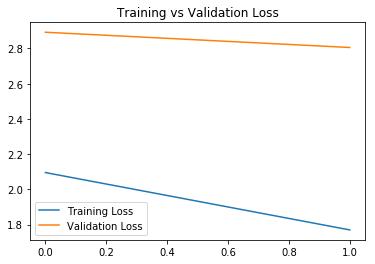

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


{'accuracy': 0.69609456380208334, 'f1_score': 0.52058302138611212, 'precision': 0.50277768489679153, 'recall_score': 0.61078947556430241}


(array([ 0.69609456,  0.50277768,  0.61078948,  0.52058302]),
 {'accuracy': 0.69609456380208334,
  'f1_score': 0.52058302138611212,
  'precision': 0.50277768489679153,
  'recall_score': 0.61078947556430241})

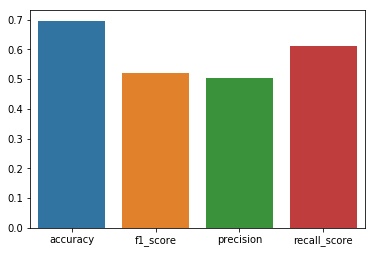

In [28]:
create_fit_predict_seq(create_model_seq_5,'model_4_seq{}'.format(appliance),
                   [xtrain_seq,ytrain_seq],[xvalid_seq,yvalid_seq],[xtest_seq,ytest_seq],
                   epochs=2,batch_size=256)